# Index VISION DOCS helper

In [1]:
%reload_ext autoreload
%autoreload 2

# INDEX DOCS VISION

In [53]:
%%writefile "../db_vision.py"
#!/usr/bin/env python 

import  os, io, torch, logging,pickle, hashlib, pickle, base64, sys
from PIL import Image 
import pdfplumber , glob, argparse, multiprocessing, ollama, gc
import numpy as np
from pdfplumber.page import Page

sys.path.append("gpt")
from gpt_utils import *

BASE = os.path.expanduser("~/data/gpt/")

#------------------------------------------INITIALIZE LLM Stuff -------------------- 
MYDB = myjson(base=BASE, db='INDICES')
INDEX_TABLE = "indexes"
#------------------------------------------------------------------------------------------ 
try:
    if (model is None or processor is None):
        pass
except:
    model, processor = None, None
    
def load_model():
    global model, processor

    if (model is not None):
        print ("*** Model already loaded! ****")
        return;

    for e in "http_proxy https_proxy HTTP_PROXY HTTPS_PROXY".split():
        if e in os.environ: del os.environ[e]

    from colpali_engine.models import ColQwen2, ColQwen2Processor

    model_name = "vidore/colqwen2-v0.1"
    modelhf =  os.path.expanduser(f"~/.cache/{model_name}/")
    modelpk = os.path.expanduser(f"~/.cache/{model_name}/")

    if os.path.exists(f'{modelpk}/model.pkl'):
        print("*** Loading from pickle file")
        with open(f'{modelpk}/model.pkl', 'rb') as f:
            model = pickle.load(f)       
        with open(f'{modelpk}/processor.pkl', 'rb') as f:
            processor = pickle.load(f)
        return

    if os.path.exists(modelhf):
        model_name = modelhf
        pass

    print(f"Model name: {model_name}")                  
    model = ColQwen2.from_pretrained( model_name, torch_dtype=torch.bfloat16, device_map=device )
    processor = ColQwen2Processor.from_pretrained(model_name)
    if (model_name !=modelhf):
        model.save_pretrained(modelhf)
        processor.save_pretrained(modelhf)

    with open( f'{modelpk}/model.pkl', 'wb') as f:
        pickle.dump(model, f)
    with open( f'{modelpk}/processor.pkl', 'wb') as f:
        pickle.dump(processor, f)
    
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def _embed(imageOrQuery):
    if (type(imageOrQuery) == str):
        batch_data = processor.process_queries([imageOrQuery]).to(model.device)
    else:
        batch_data = processor.process_images([imageOrQuery]).to(model.device)

    with torch.no_grad():
        embeddings = model(**batch_data)
    embedding = embeddings[0].cpu().to(torch.float32).numpy()
    return embedding

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def embed(file, db={}):
    assert db is not None, "DB cannot be None"

    if ( file.endswith(".pdf")):
        with pdfplumber.open(file) as doc:
            for i, page in enumerate(doc.pages):
                image = page.to_image(resolution=400)
                buffer = io.BytesIO()
                image.save(buffer, format="PNG")
                image = Image.open(buffer)
                e =_embed(image)
                img_str = base64.b64encode(buffer.getvalue()).decode()
                addDB(file, e, image, img_str, dict(page=i, file=file), db=db)
    else:
        image_data = open(file, "rb").read()

        image = Image.open(io.BytesIO(image_data)).convert('RGB')
        buffer = io.BytesIO()
        image.save(buffer, format="PNG")
        e =_embed(image)
        img_str = base64.b64encode(buffer.getvalue()).decode()
        addDB(file, e, image, img_str, dict(page=0, file=file), db=db)

    return e, img_str

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def adjustSeq(to_len, embedding):
    seq_len, edim = embedding.shape

    if seq_len < to_len:
        padding = np.zeros((to_len - seq_len, edim), dtype=embedding.dtype)
        embedding_fixed = np.concatenate([embedding, padding], axis=0)
    elif seq_len > to_len:
        embedding_fixed = embedding[:to_len, :]
    else:
        embedding_fixed = embedding  
        
    return embedding_fixed

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def searchVision(query, DB, nItems=1):
    query_embed = _embed(query)

    with torch.no_grad():
        image_embeddings_list = []
        image_base64_list = []

        for k,v in DB.items():
            image_base64, embedding = v['img_str'], v['embedding']
            embedding_fixed = adjustSeq(MAX_SEQ_LEN, embedding)
            image_embeddings_list.append(embedding_fixed)
            image_base64_list.append(image_base64)

        # Stack embeddings
        retrieved_image_embeddings = np.stack(image_embeddings_list)

        # Convert to tensors
        query_embedding_fixed = adjustSeq(MAX_SEQ_LEN, query_embed)
        q_tensor = torch.from_numpy(query_embedding_fixed).to(model.device).unsqueeze(0)
        embeddings_tensor = torch.from_numpy(retrieved_image_embeddings).to(model.device)

        # Compute similarity scores
        with torch.no_grad():
            scores = processor.score_multi_vector(q_tensor, embeddings_tensor)

        scores_np = scores.cpu().numpy().flatten()
        #del q_tensor, embeddings_tensor, scores 

        # Combine images and scores
        similarities = list(zip(image_base64_list, scores_np))

        # Sort by similarity
        similarities.sort(key=lambda x: x[1], reverse=True)

        ret = []
        for s in similarities[0:nItems]:
            img_str, score = s
            img_data = base64.b64decode(img_str)
            image = Image.open(io.BytesIO(img_data))
            ret.append([image, img_data, img_str])
            #print([s[1] for s in similarities])

        return ret

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def askLLM(query, img_data, model="llama3.2-vision"):
    load_model()
    stream = ollama.chat(
        model=model,
        messages=[
            {
                'role': 'user',
                'content': "Please answer the following question using only the information visible in the provided image" 
                " Do not use any of your own knowledge, training data, or external sources."
                " Base your response solely on the content depicted within the image."
                " If there is no relation with question and image," 
                f" you can respond with 'Question is not related to image'.\nHere is the question: {query}",
                'images': [img_data]
            }
        ],
        stream=True
    )
    collected_chunks = []
    stream_iter = iter(stream)

    # Continue streaming the rest of the response
    for chunk in stream_iter:
        chunk_content = chunk['message']['content']
        collected_chunks.append(chunk_content)
        complete_response = ''.join(collected_chunks)

    print(complete_response)
    #clear_cache()
    gc.collect()
    return complete_response

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def queryVision(query, dbPath, DB=None, model="llama3.2-vision", **kwargs):
    load_model()
    if (  DB is None and not dbPath):
        print("You must pass DB or dbPath to locate database", DB is None, dbPath)
        return None
    elif ( DB is None ):
        DB = loadDB(dbPath )

    ret = searchVision(query, DB)
    if ( ret ):
        img, img_data, img_str = ret[0]
        resp = askLLM(query, img_data, model)
        imgsrc = '<img style="width:100%;" src="data:image/svg;base64,' + str(img_str) + '" />'
        ret = f"{resp}\n\n{imgsrc}"
    else:
        ret = f"No relevant information"

    return ret
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
MAX_EMBEDDING_SEQ = 0
MAX_SEQ_LEN       = 620
#MAX_SEQ_LEN = min(MAX_SEQ_LEN, MAX_EMBEDDING_SEQ)
DB = {}
def addDB(file, embedding, image, img_str,metadata="", db=DB):
    global MAX_EMBEDDING_SEQ, MAX_SEQ_LEN
    entry = locals()
    del entry['db']

    h = hashlib.md5(img_str.encode())
    db[str(h.hexdigest()) ] = dict(entry)

    MAX_EMBEDDING_SEQ = max(MAX_EMBEDDING_SEQ, embedding.shape[0])

# ---------------------------------------------------------------------------------------
def makename(folder, index_name=""):
    #visionDBName= f"{folder}/DB.{index_name}.pkl"
    # Since we do not care for any other parameters, w will ignore index_name
    visionDBName= f"{folder}/DB.pkl"
    return os.path.expanduser(visionDBName)

SAVED_DBs = {}

def loadDB(picklefile, use_cache=1):
    picklefile = os.path.expanduser(picklefile)
    if (not picklefile.endswith("pkl")):
        if ( os.path.isdir(picklefile) ):
            picklefile= makename(picklefile)
        else:
            assert (0), f"Programming error: {picklefile} - please check"

    if (use_cache and picklefile in SAVED_DBs):
        db, stat = SAVED_DBs[picklefile]
        stat1 = os.stat(picklefile)
        if (stat.st_mtime < stat.st_mtime):
            print("Found in cache but DB is new")
        else:
            print("Found in cache!")
            return db

    db = {}
    picklefile = os.path.expanduser(picklefile)
    if os.path.exists( picklefile):
        with open( picklefile, 'rb') as f:
            db = pickle.load(f)

    assert (db), f"Programming error: {picklefile} - no DB!!"

    stat1 = os.stat(picklefile)
    SAVED_DBs[picklefile] = [db, stat1]
    return db

def saveDB(picklefile, db=DB):
    with open( picklefile, 'wb') as f:
        pickle.dump(db, f)
    return db
# ---------------------------------------------------------------------------------------
# model is always CoQwen2
#
def indexFromFolder(folder="", files=[], force=0, index_name="", **kwargs):
    load_model()
    folder = os.path.expanduser(folder)
    if (not files):
        files = [f for f in glob.glob(folder + "/*", recursive=0) if os.path.isfile(f)]

    logger.info(f"Indexing files from {folder}: found {len(files)} files.")

    visionDBName= makename(folder,index_name)
    db = loadDB(visionDBName)

    S= set([d['file'] for d in db.values()])

    for f in files:
        if f in S:
            print(f"{f} already indexed")
            continue

        logger.info(f"Indexing {f}")       
        bname, ext = os.path.splitext(f)

        if ( ext in ".pdf .png .jpeg .jpg .gif .webp" ):
            embed(f, db=db)
        else:
            print(f"Later!! {f} not a known extensions oki doki!!!!")
            continue
            
        saveDB(visionDBName, db=db)
    return db

#-----------------------------------------------------------------------------------
sysargs=None
def addargs(argv=sys.argv):
    import argparse
    global sysargs
    p = argparse.ArgumentParser(f"{os.path.basename(argv[0])}:")
    p.add_argument('-p', '--path',   type=str, required=True, help="where files are located to index")
    p.add_argument('-f', '--force',  required=False, default=False, action='store_true', help="force")

    sysargs=p.parse_args(argv[1:])
    return sysargs

from colabexts import utils as colabexts_utils
if __name__ == '__main__' and not colabexts_utils.inJupyter():
    a = addargs()
    logger.info(f"Indexing  {sysargs}")
    load_model()
    indexFromFolder(folder=a.path, force=a.force )


Overwriting ../db_vision.py


In [45]:
dbPath= "~/data/gpt/test-files/"
#db = indexFromFolder (dbPath)
db = loadDB(dbPath)
len(db)

3737

*** Model already loaded! ****


INFO:colpali_engine.utils.torch_utils 2024-12-30 01:52:45,027 torch_utils.py:29:get_torch_device: Using device: mps


*** Model already loaded! ****


INFO:httpx 2024-12-30 01:53:08,809 _client.py:1038:_send_single_request: HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


The provided document is a page from an operations manual for a spacecraft, specifically detailing procedures for attitude reorientation slews. The text discusses various aspects of these maneuvers, including the importance of aligning the solar arrays with the Sun.

**Key Information**

*   The rotation axis of the solar arrays is not explicitly mentioned in this section.
*   However, it can be inferred that the rotation axis would be along the same axis as the spacecraft's attitude, which is typically defined by the Sun-centered reference frame (SCR).

**Conclusion**

Based on the information provided and typical spacecraft design practices, the rotation axis of the solar arrays is likely aligned with the SCR.
394147 The provided document is a page from an operations manual for a 



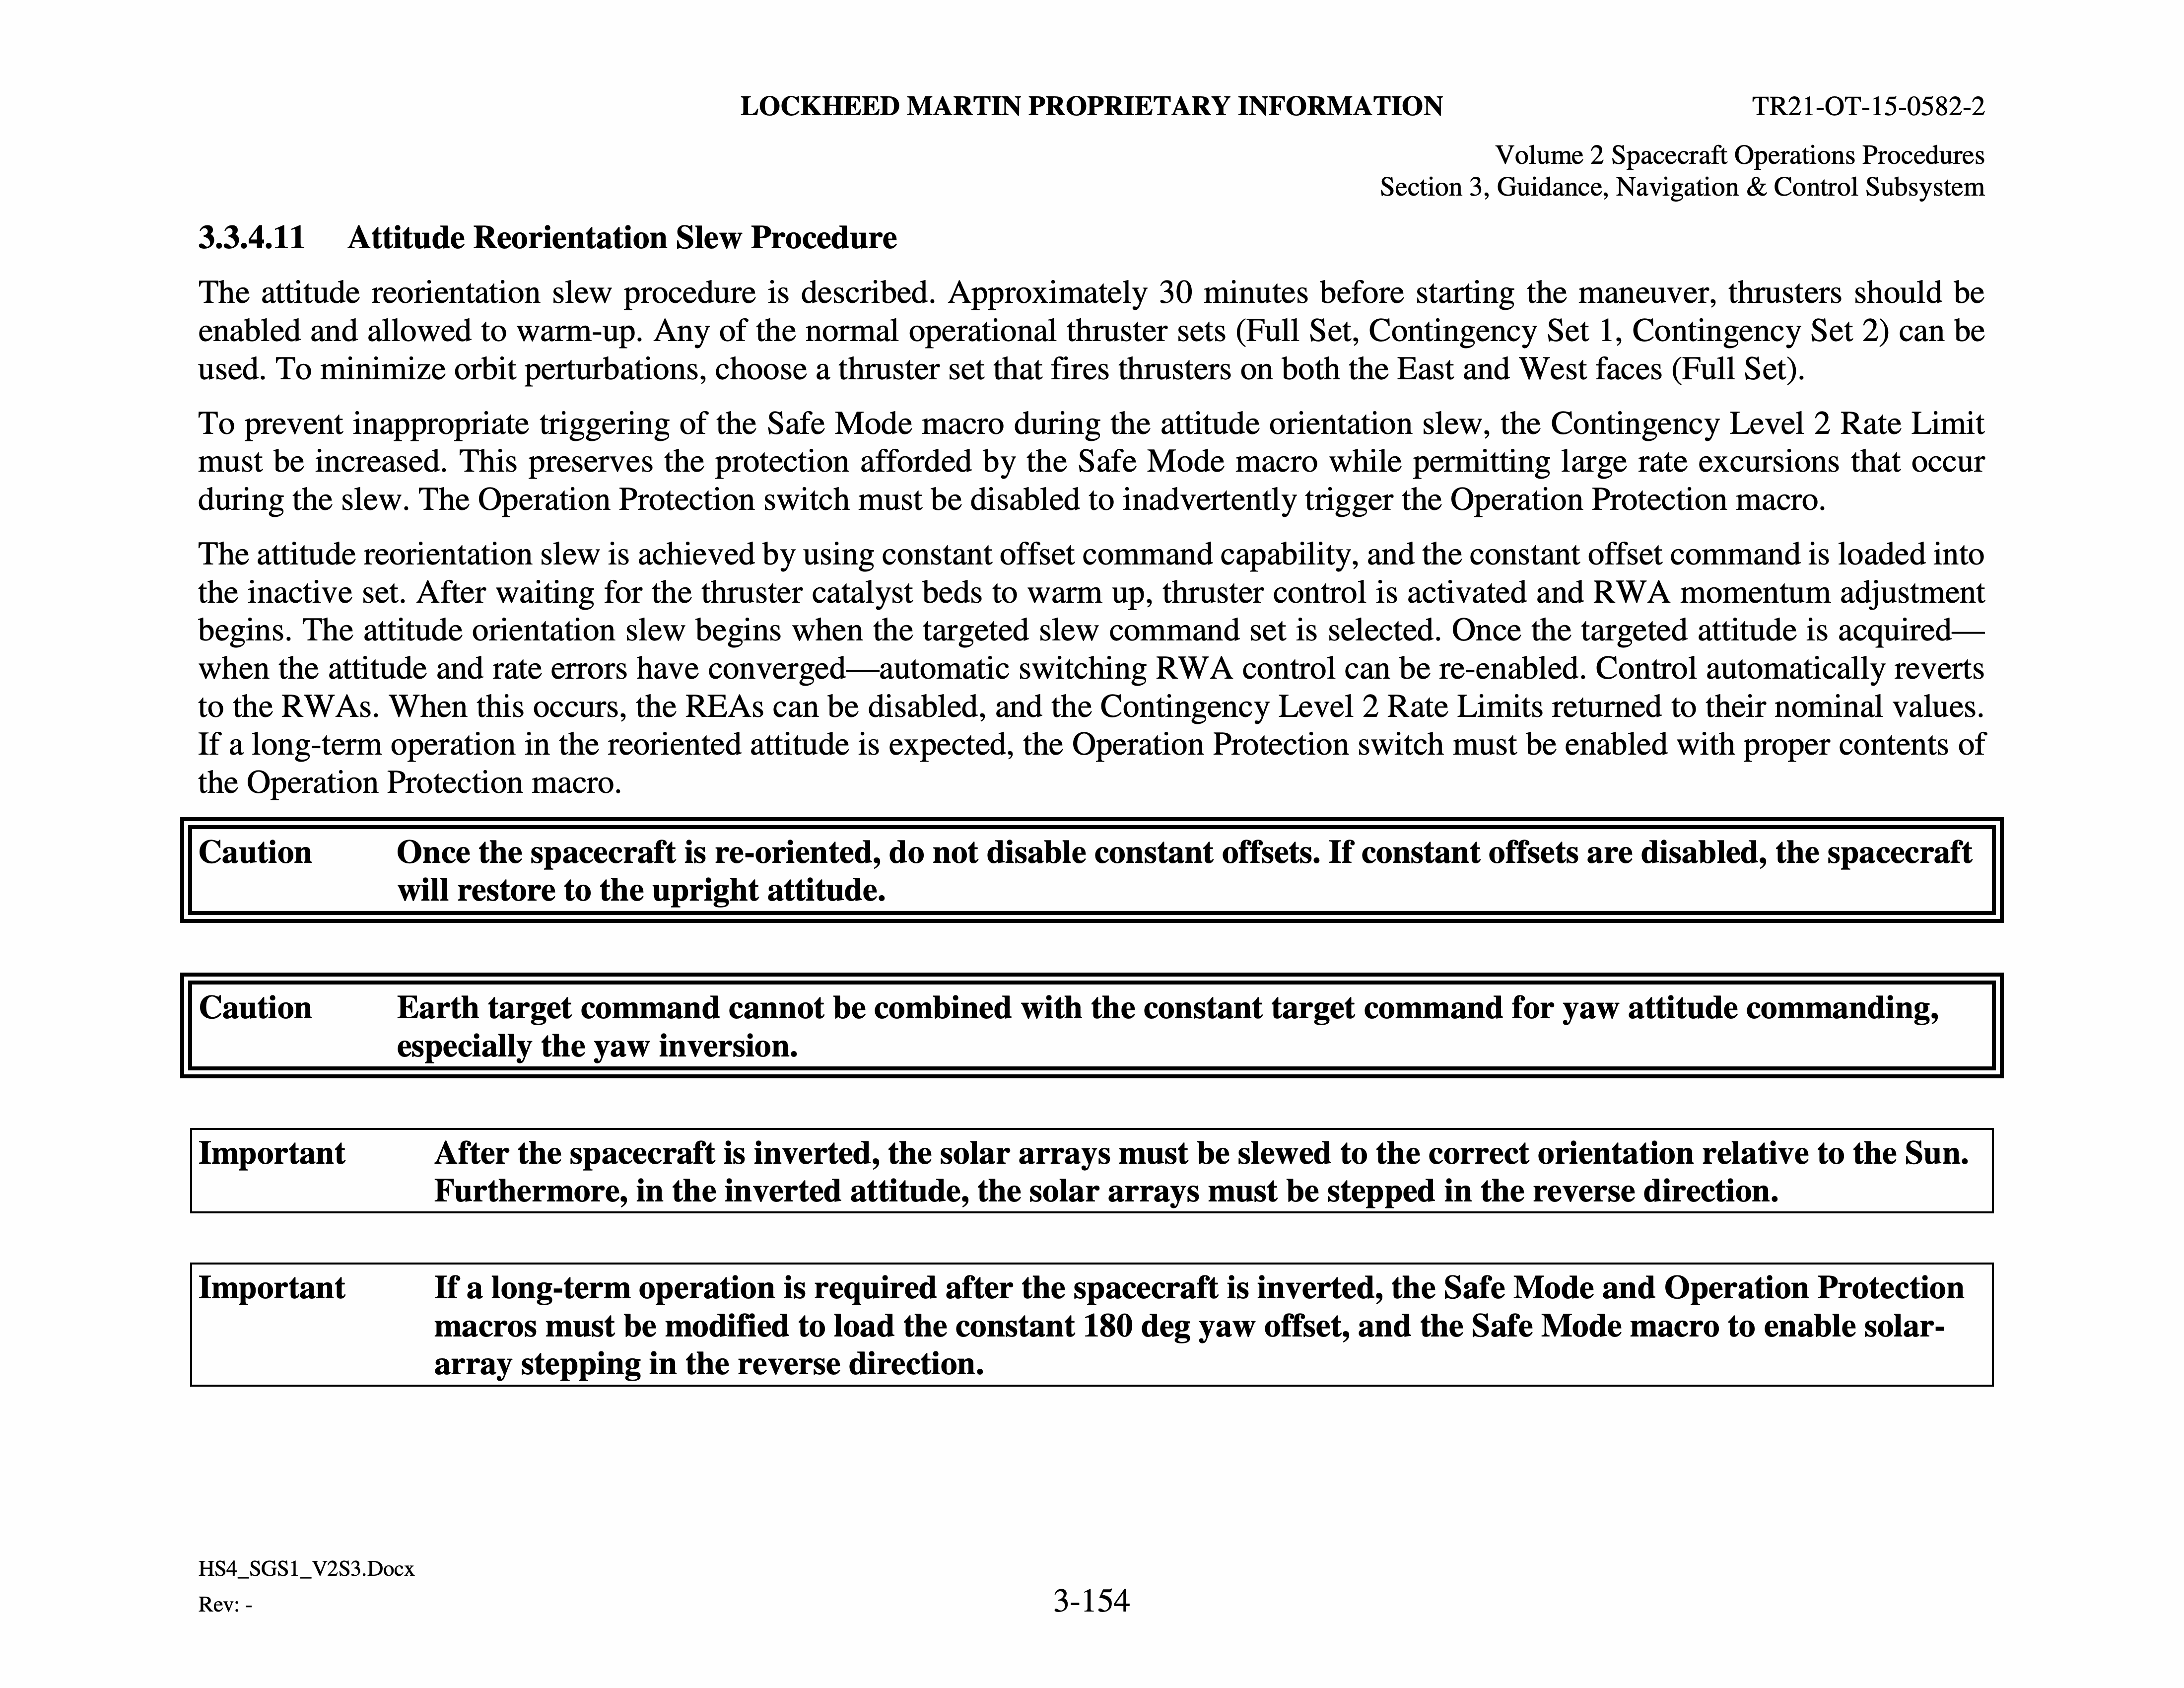

In [47]:
from IPython.core.display import HTML
query = "What is the rotation axis of the solar arrays?"
#query = "What is the specific impulse of the LAE?"
#query = "What mode is used for Stationkeeping maneuvers?"
#query = "what is diameter of SYLDA5"
#query = "which component is attached to cryogenic main core stage (EPC)"
    
out = queryVision(query, None, DB=db)
print(len(out), out[0:64])
display(HTML(out))

# Test

In [ ]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
files = [
    "/Users/e346104/Desktop/data/images/table.png",
    "/Users/e346104/Desktop/data/LLM/sample.pdf",
    "/Users/e346104/Desktop/data/LLM/HS4_SGS1_V1S7.pdf"
]
load_model()
indexFromFolder(".", files)

# CALL vision model